In [ ]:
import os
path = os.path.abspath(os.path.join("..", "language-modeling"))
%cd $path

In [2]:
import yaml
import math
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report

import torch
import torch.nn.functional as F

from IPython.display import display

from run import inference


In [ ]:
with open("configs/inference.yaml", "r") as f:
    inf_config = yaml.safe_load(f)

In [3]:
def load_pickle(filename: str):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [4]:
def plot_ppl_per_len(df):
    df = df[['lengths', 'loss']]
    df['lengths'] = df.apply(lambda x: list(x["lengths"])[0], axis=1)
    df = df.groupby("lengths").mean()
    df["ppl"] = df.apply(lambda x: math.exp(x["loss"]), axis=1)
    df.plot(
        y="ppl", 
        title="Perplexity by sequence length", 
        kind="bar",
        xlabel="Sentence length",
        ylabel="Average perplexity",
        rot=0,
        xticks=range(0, 70, 10),
        legend=False,)
    plt.show()

In [5]:
def fetch_predictions(outputs):
    outputs = torch.tensor(outputs)
    softmax = F.softmax(outputs, dim=1)
    predictions = torch.argmax(softmax, dim=1)
    return predictions.numpy()

def get_counts(df, col, lang):
    if col == "outputs":
        df["outputs"] = df.apply(lambda pred: fetch_predictions(pred["outputs"]), axis=1)
    counts = Counter()
    for row in df[col]:
        try:
            counts.update(row)
        except TypeError:
            counts.update([int(row)])
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
    counts = {lang.ids2words[k]: v  for (k, v) in counts.items()}
    return counts

In [6]:
def plot_targets_vs_preds(targets, preds):
    targets_df = pd.DataFrame(targets.items(), columns=["word", "target_count"])
    total = targets_df["target_count"].sum()
    targets_df["target_freq"] = targets_df["target_count"] / total
    targets_df["pred_count"] = pd.Series(preds.values())
    targets_df["pred_count"] = targets_df["pred_count"].fillna(0).astype(int)
    targets_df["diff"] = targets_df["pred_count"] - targets_df["target_count"]
    targets_df["pred_freq"] = targets_df["pred_count"] / total
    return targets_df

In [29]:
def report(df, targets_counts, outputs_counts, lang, mode="most"):
    if mode == "most_present":
        ids = set([lang.words2ids[w] for w in list(targets_counts.keys())[:20]])
    elif mode == "most_guessed":
        ids = set([lang.words2ids[w] for w in list(outputs_counts.keys())[:20]])
    elif mode == "least_guessed":
        ids = set([lang.words2ids[w] for w in list(outputs_counts.keys())[-20:]])
    targets = []
    preds = []
    for _, row in df.iterrows():
        rt = row["targets"].tolist()
        rp = row["outputs"].tolist()
        try:
            for t, p in zip(rt, rp):
                if (t in ids or p in ids):
                    targets.append(t)
                    preds.append(p)
        except TypeError:
            targets.append(rt)
            preds.append(rp[0]) 
    report = classification_report(targets, preds, labels=list(ids), target_names=[lang.ids2words[i] for i in ids], output_dict=True)
    display(pd.DataFrame(report).transpose())

In [31]:
def evaluate(experiment_name: str):
    results = load_pickle(f"results/outputs/{experiment_name}.pkl")
    lang = load_pickle("lang.pkl")
    df = pd.DataFrame(results)
    display(df)
    plot_ppl_per_len(df)
    targets = get_counts(df, "targets", lang)
    outputs = get_counts(df, "outputs", lang)
    diff = plot_targets_vs_preds(targets, outputs)
    pd.options.display.float_format = '{:.2%}'.format
    display(diff)
    pd.options.display.float_format = '{:.2}'.format
    report(df, targets, outputs, lang, mode="most_present")
    report(df, targets, outputs, lang, mode="most_guessed")
    report(df, targets, outputs, lang, mode="least_guessed")
    with open(f"configs/{experiment_name}.yaml") as config_file:
        config = yaml.safe_load(config_file)
    inference(config, inf_config, "the")

,inputs,targets,lengths,outputs,loss
0,"[142, 78, 54, 251, 2360, 405]","[78, 54, 251, 2360, 405, 10000]",[6],"[[-2.2921162, -3.2863421, -2.1783075, -2.55128...",5.51813
1,"[315, 706, 32, 101, 934, 935, 936, 874, 251, 5...","[706, 32, 101, 934, 935, 936, 874, 251, 572, 5...",[37],"[[-2.5192566, -3.3079512, -3.1927047, -2.72376...",3.6542494
2,"[307, 954, 4419, 3882, 424, 32, 687, 27, 1745,...","[954, 4419, 3882, 424, 32, 687, 27, 1745, 1884...",[26],"[[-2.3772712, -2.8581948, -2.1955106, -2.16599...",5.1269255
3,"[32, 27, 935, 2737, 1292, 152, 32, 812, 33, 44...","[27, 935, 2737, 1292, 152, 32, 812, 33, 4402, ...",[32],"[[-2.141458, -1.0489342, -2.1165955, -1.253909...",4.7702303
4,"[812, 1623, 1375, 2569, 64, 2775, 95, 64, 32, ...","[1623, 1375, 2569, 64, 2775, 95, 64, 32, 2141,...",[24],"[[-2.3761134, -1.2713917, -1.8186976, -1.47347...",4.0040145
...,...,...,...,...,...
3756,"[853, 2574, 26, 312, 42, 32, 682, 4921, 4464, ...","[2574, 26, 312, 42, 32, 682, 4921, 4464, 504, ...",[22],"[[-2.1350505, -2.116829, -3.1194227, -2.602402...",4.5987835
3757,"[374, 2173, 380, 1287, 64, 220, 1729, 2083]","[2173, 380, 1287, 64, 220, 1729, 2083, 10000]",[8],"[[-2.0035403, -2.6829042, -2.4385731, -2.47021...",5.372224
3758,"[160, 710, 2378, 119, 3302, 374, 1134, 152, 55...","[710, 2378, 119, 3302, 374, 1134, 152, 556, 26...",[20],"[[-2.9068222, -2.2648683, -3.218254, -1.668448...",5.0701585
3759,"[130, 26, 7649, 373, 130, 2573, 93, 32, 499, 4...","[26, 7649, 373, 130, 2573, 93, 32, 499, 40, 17...",[24],"[[-2.3578959, -3.2964883, -2.728866, -3.145028...",4.543903


/tmp/ipykernel_4505/2585029102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lengths'] = df.apply(lambda x: list(x["lengths"])[0], axis=1)


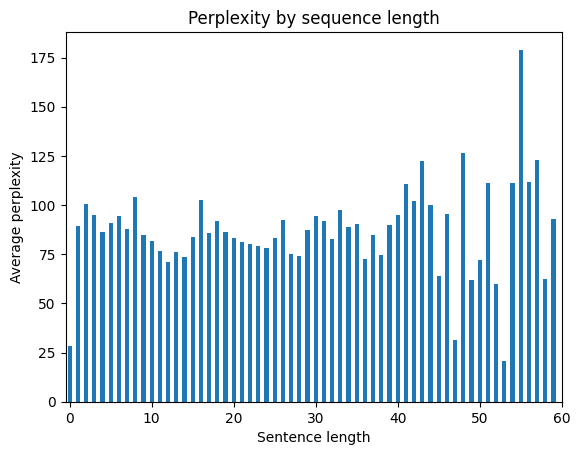

,word,target_count,target_freq,pred_count,diff,pred_freq
0,<unk>,4606,5.85%,14465,9859,18.39%
1,the,3968,5.04%,12240,8272,15.56%
2,<eos>,3761,4.78%,9367,5606,11.91%
3,N,2494,3.17%,3637,1143,4.62%
4,of,2182,2.77%,3195,1013,4.06%
...,...,...,...,...,...,...
5973,external,1,0.00%,0,-1,0.00%
5974,wings,1,0.00%,0,-1,0.00%
5975,inside,1,0.00%,0,-1,0.00%
5976,instructed,1,0.00%,0,-1,0.00%


,precision,recall,f1-score,support
<eos>,0.28,0.7,0.4,3.8e+03
on,0.4,0.14,0.2,4.8e+02
<unk>,0.15,0.48,0.23,4.6e+03
N,0.55,0.71,0.62,2.5e+03
the,0.23,0.7,0.34,4e+03
$,0.4,0.47,0.43,5.4e+02
as,0.54,0.22,0.32,4.3e+02
a,0.2,0.27,0.23,1.7e+03
is,0.14,0.27,0.19,6.6e+02
of,0.38,0.64,0.48,2.2e+03


,precision,recall,f1-score,support
<eos>,0.28,0.7,0.4,3.8e+03
<unk>,0.15,0.48,0.23,4.6e+03
N,0.55,0.71,0.62,2.5e+03
are,0.15,0.37,0.21,3.6e+02
the,0.23,0.7,0.34,4e+03
$,0.4,0.47,0.43,5.4e+02
a,0.2,0.27,0.23,1.7e+03
is,0.14,0.27,0.19,6.6e+02
been,0.21,0.85,0.34,1.6e+02
of,0.38,0.64,0.48,2.2e+03


/media/pips/Data/Projects/NLU-UniTN-2022/project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/pips/Data/Projects/NLU-UniTN-2022/project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/pips/Data/Projects/NLU-UniTN-2022/project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

,precision,recall,f1-score,support
surpluses,0.0,0.0,0.0,0.0
refused,0.0,0.0,0.0,4.0
restated,0.0,0.0,0.0,1.0
sports,0.0,0.0,0.0,4.0
movement,1.0,0.5,0.67,2.0
florida,0.0,0.0,0.0,1.2e+01
bronx,0.0,0.0,0.0,1e+01
kemp,0.0,0.0,0.0,0.0
africa,1.0,0.25,0.4,4.0
organization,0.0,0.0,0.0,4.0



t:0.5 => the u.s. was the first of the nation 's largest markets <eos>
t:0.7 => the of the government is nsc the host of the votes <eos>
t:0.75 => the state of wisconsin and the are more than N <eos>
t:0.8 => the go to the some also said <eos>
t:1.0 => the previous thing is that <eos>


In [32]:
evaluate("results")